## Requirements
On importe toutes les librairies nécéssaires

In [1]:
import numpy as np
import re
import pandas as pd
#!pip install unidecode
from unidecode import unidecode
import torch

In [2]:
from PyPDF2 import PdfReader

In [3]:
import os
pd.set_option('mode.chained_assignment', None)
import s3fs

In [4]:
import matplotlib.pyplot as plt

## Fonctions

In [30]:
def normalize_text(s):
    """removing caractères, /, accents, m3, /n"""
    import string, re
    
    def no_unit(text):
        regex="m3"
        return re.sub(regex, " ", text)
    def no_exp(text):
        regex="m³"
        return re.sub(regex, " ", text)
    def no_punct(text):
        regex="\\.(?!\d)"
        return re.sub(regex," ",text)
   
    def white_space_fix(text):
        return " ".join(text.split())
    def no_date(text):
        date_extract_pattern = "[0-9]{1,2}\\/[0-9]{1,2}\\/[0-9]{4}"
        return re.sub(date_extract_pattern,"",text)
    def special_char(text):
        regex=regex = "[^\w\s,.]"
        return re.sub(regex, " ", text)
   #on retire tout les caractère des réponses 
    def no_char(text):
        regex=r"([a-zA-Z])"
        return re.sub(regex, " ", text)
    def comma(text):
        regex=",(?!\d)"
        return re.sub(regex," ",text)
    def point(text):
        return re.sub("\,",".",text)
    def indic(text):
        regex="(P\d\d\d\\.\d\s*)|(D\d\d\d\\.\d\s*)|(VP\\.\d\d\d)"
        return re.sub(regex," ", text)

    return white_space_fix(point(no_punct(no_char(unidecode(comma(special_char(indic(no_exp(no_unit(no_date(s)))))))))))

In [31]:
def normalize(s):
    """removing caractères, /, accents, m3, /n"""
    import string, re
    def no_punct(text):
        regex="\\.(?!\d)"
        return re.sub(regex," ",text)
    def white_space_fix(text):
        return " ".join(text.split())
    def special_char(text):
        regex=regex = "[^\w\s,.]"
        return re.sub(regex, " ", text)
    def comma(text):
        regex=",(?!\d)"
        return re.sub(regex," ",text)
    def lower(text):
        return text.lower()

    return white_space_fix(no_punct(unidecode(lower(special_char(s)))))

In [32]:
def white_space_fix(text):
        return " ".join(text.split())

In [33]:
def lower(text):
        return text.lower()

In [34]:
def saut(text):
        regex="\n"
        return re.sub(regex,"",text)

In [35]:
def compute_f1(prediction, truth):
    pred_tokens =normalize(prediction).split()
    truth_tokens = normalize(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    #print(len(common_tokens))
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

## Charger les modèles
On charge le modèle de question réponse d'etalab pour appliquer les pré-filtres, puis le modèle T5 pour récupérer les valeurs d'indicateurs.

In [11]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl", device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
from transformers import pipeline
nlp = pipeline('question-answering', model='etalab-ia/camembert-base-squadFR-fquad-piaf', tokenizer='etalab-ia/camembert-base-squadFR-fquad-piaf')

## Charger les données de SISPEA
On charge le documents contenant toutes les questions: associées à un mot clé et à un indicateur

In [7]:
FILE_KEY_Q = "camemBERT/data_2020_AC.xlsx" #Nom du fichier chargé depuis sispea

In [8]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "/mberthe/narval"
FILE_PATH_Q = BUCKET + "/" + FILE_KEY_Q

with fs.open(FILE_PATH_Q,  mode="rb") as file_in:
       df = pd.read_excel(file_in)


In [14]:
for i in df.index:
    df["Nom collectivité"][i]=lower(df["Nom collectivité"][i])

In [15]:
df.sample(15)

,DPT du siège de la coll.,Id SISPEA de la collectivité,Nom collectivité,Courriels des utilisateurs collectivité,Type collectivité,N° SIREN,N° INSEE si commune,Communes membres de la coll,Avec ou sans CCSPL,Collecte,...,VP.256,VP.257,VP.258,VP.259,VP.260,VP.261,VP.262,VP.265,VP.266,VP.268
7022,070,106372,neuvelle-lès-la-charité,mairie.neuvelleleslacharite@orange.fr,Commune,217003847.0,70384,1,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8802,088,216994,syndicat intercommunal du breuil (88),syndicatbreuil@orange.fr,Syndicat Intercommunal à Vocation Unique,200026151.0,NaN,2,Non,Non,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152,061,135617,croisilles,mairie.croisilles61@wanadoo.fr,Commune,216101386.0,61138,0,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8841,088,198830,dolaincourt,dolaincourt@wanadoo.fr,Commune,218801371.0,88137,1,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8349,082,221754,cc quercy vert-aveyron,"n.banzato@quercyvertaveyron.fr,contact@quercyv...",Communauté de communes,200066884.0,NaN,13,Inconnu,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
833,011,184542,albas,NaN,Commune,211100060.0,11006,1,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4068,038,38389,lavaldens,mairie.lavaldens@wanadoo.fr,Commune,213802077.0,38207,1,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8128,079,235674,communauté de communes mellois en poitou,eva.pinto@melloisenpoitou.fr,Communauté de communes,200069755.0,NaN,62,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13162.0
5905,058,153792,s.i.a.e.p.a. de druy-parigny,severinefavard@syndicat-eau.fr,Syndicat Intercommunal à Vocation Unique,255800377.0,NaN,6,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2211,024,211678,saint-capraise-de-lalinde,mairie.stcapraise-lalinde@wanadoo.fr,Commune,212403828.0,24382,1,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Charger les questions

In [17]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "/mberthe/narval"
FILE_KEY_Q = "camemBERT/question_all.csv"
FILE_PATH_Q = BUCKET + "/" + FILE_KEY_Q

with fs.open(FILE_PATH_Q,  mode="r") as file_in:
    question=pd.read_csv(file_in)

In [18]:
question

,question,mot,indic
0,Quel est le prix de service au m3 pour l'eau p...,prix,D102.0
1,Quel est le prix du service au m3 pour l'assin...,prix,D204.0
2,Quelle est la connaissance du réseau en eau po...,connaissance,P103.2B
3,Quel est le taux de connaissance du réseau en ...,connaissance,P202.2B
4,Quel est le taux de renouvellement des réseaux...,renouvellement,P107.2
...,...,...,...
97,Quelle est la valeur de l'endettement du servi...,dette,P256.2
98,Quelle est la valeur de l'endettement du servi...,endettement,P256.2
99,Quelle est la valeur de l'endettement du servi...,dette,P153.2
100,Quel est le total de points de connaissance d...,connaissance,P202.2B


## Pré-filtres
On récupère les premieres pages du rapport, desquelles on extrait l'année du rapport aisni que le type de service proposé 

In [19]:
nom_fichier='PDF/plassac_AC_2016.pdf'

In [20]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "mberthe/narval"
fs.ls(BUCKET)
BUCKET = "mberthe/narval"
FILE_KEY_S3 = nom_fichier #entrer le nom du PDF
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    reader = PdfReader(file_in)
    page=reader.pages
    text=[]
    for i in range(0,5):
        page = reader.pages[i]
        output = page.extract_text()
        text.append(output)
    

In [21]:
text1=''
for x in text:
    text1 +=' '+ x

In [22]:
#text1

#### Le type de service

In [23]:
reau= "eau potable"
rass="assainissement"

d=nlp({'question': "Quels types de services ? ",
         'context': text1})
print(d)
prediction=d["answer"]
prediction=normalize(prediction)
if ((re.findall(reau,prediction)==[])&(re.findall(rass,prediction)==[])):
    d=nlp({'question': "eau potable ou assainissement collectif ? ",
         'context': text1})
    print(d)
    prediction=d["answer"]
    prediction=normalize(prediction)
    if ((re.findall(reau,prediction)==[])&(re.findall(rass,prediction)==[])):
        d=nlp({'question': "Quelle est l'entité de gestion ? ",
         'context': text1})
        print(d)
        prediction=d["answer"]
        prediction=normalize(prediction)
    if ((re.findall(reau,prediction)==[])&(re.findall(rass,prediction)==[])):
            print("type de service non retrouvé dans le texte")

{'score': 0.6186914443969727, 'start': 1492, 'end': 1519, 'answer': ' l’assainissement collectif'}


Grâce à notre réponse sur le service, et la métrique f1, on choisit la liste d'indicateur appropriée

In [24]:
truth="""eau potable"""
prediction=d['answer']
print(prediction)
f1_ep=compute_f1(prediction,truth)
print('f1 eau potable:',f1_ep)

truth="""assainissement"""
prediction=normalize(d['answer'])
f1_ac=compute_f1(prediction,truth)
print('f1 assainissement:',f1_ac)

if ((re.findall(reau,prediction)!=[])&(re.findall(rass,prediction)!=[])):
    print(re.findall(reau,prediction),re.findall(rass,prediction))
    indic=["D102.0","D204.0","P103.2","P202.2","P107.2","P253.2","P109.0","P207.0","P153.2","P256.2","P154.0","P257.0","P155.1","P258.1","P101.1","P102.1","P104.3","P105.3","P106.3","P108.3","P151.1","D203.0","P201.1","P204.3","P205.3","P206.3","P251.1","P252.2","P254.3","P255.3","D302.0","P301.3"]
    service="AC+EP"
else:
    if (f1_ep > f1_ac ):
        indic=["D102.0","P103.2B","P107.2","P109.0","P153.2","P154.0","P155.1","P101.1","P102.1","P104.3","P105.3","P106.3","P108.3","P151.1"]
        service="EP"
    if (f1_ep < f1_ac):
        indic=["D204.0","P202.2B","P253.2","P207.0","P256.2","P257.0","P258.1","D203.0","P201.1","P204.3","P205.3","P206.3","P251.1","P252.2","P254.3","P255.3","D302.0","P301.3"]
        service="AC"
if(f1_ep==0)&(f1_ac==0):
         indic=["D102.0","D204.0","P103.2B","P202.2B","P107.2","P253.2","P109.0","P207.0","P153.2","P256.2","P154.0","P257.0","P155.1","P258.1","P101.1","P102.1","P104.3","P105.3","P106.3","P108.3","P151.1","D203.0","P201.1","P204.3","P205.3","P206.3","P251.1","P252.2","P254.3","P255.3","D302.0","P301.3"]
         service="Not defined"
print(indic)
print(service)

 l’assainissement collectif
f1 eau potable: 0
f1 assainissement: 0.5
['D204.0', 'P202.2B', 'P253.2', 'P207.0', 'P256.2', 'P257.0', 'P258.1', 'D203.0', 'P201.1', 'P204.3', 'P205.3', 'P206.3', 'P251.1', 'P252.2', 'P254.3', 'P255.3', 'D302.0', 'P301.3']
AC


#### L'année du rapport

In [115]:
année=nlp({'question': "Quelle est l'année d'exercice du rapport ?",
         'context': text1})
print(année)

{'score': 0.7999693155288696, 'start': 6986, 'end': 6991, 'answer': ' 2021'}


In [116]:
an=normalize_text(année['answer']) # on normalise la réponse afin de n'avoir que l'année 

#### La ville
Pour comparer avec les résultats prédits

In [117]:
d_ville=nlp({'question': "Quel est le nom de la ville?",
         'context': text1})
ville1=d_ville['answer']
print(ville1)

 SAINT  VICTOR


In [118]:
d_ville=nlp({'question': "Quel est le nom de la collectivité?",
         'context': text1})
ville2=d_ville['answer']
print(ville2)

 SAINT  VICTOR


In [119]:
cols=df.columns

In [120]:
df_ville=pd.DataFrame(columns=[cols])
f1=0
row_list=[]
ind=''
for i in df_publi.index:
    if normalize(df["Nom collectivité"][i])==normalize(ville2):
        print('ville trouvée',i,df["Nom collectivité"][i],ville1)
        row_list.append(df_publi.loc[i])
df_ville=pd.DataFrame(row_list)
ville=normalize(ville1)
print(ville)
if df_ville.empty:
    ('empty2')
    for i in df_publi.index:
            #print(type(f1))
            if compute_f1(df["Nom collectivité"][i],ville) > f1:
                print(i)
                ind=i 
                f1=compute_f1(df["Nom collectivité"][i],ville)
    if not ind:
        print('ville not found')
    else:
        row_list.append(df_publi.loc[ind])
        df_ville=pd.DataFrame(row_list)
        print(df_publi["Nom collectivité"][ind])
        print(ind)
            
        

ville trouvée 2305 saint-victor  SAINT  VICTOR
saint victor


In [121]:
df_ville

,DPT du siège de la coll.,Id SISPEA de la collectivité,Nom collectivité,Courriels des utilisateurs collectivité,Type collectivité,N° SIREN,N° INSEE si commune,Communes membres de la coll,Avec ou sans CCSPL,Collecte,...,VP.256,VP.257,VP.258,VP.259,VP.260,VP.261,VP.262,VP.265,VP.266,VP.268
2305,024,137299,saint-victor,"saintvictor.mairie@wanadoo.fr,s.daniel@atd24.fr",Commune,212405088.0,24508,1,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.54


In [122]:
df_ville.empty

False

## On charge tout le texte du PDF
On va maintenant extraire les valeurs des RPQS

In [380]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "mberthe/narval"
fs.ls(BUCKET)
BUCKET = "mberthe/narval"
FILE_KEY_S3 = nom_fichier # entrer le nom du PDF
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    reader = PdfReader(file_in)
    page=reader.pages
    count = len(reader.pages)
    print(count)
    text=[]
    for i in range(count):
        page = reader.pages[i]
        output = page.extract_text()
        text.append(output)

37


In [124]:
pages =[]
for i in question.index:
    my_list=[]
    if question["indic"][i] in indic:
        for j in text:
            #print(re.findall(f1["mot"][i],j))
                if (re.findall(question["mot"][i],j)!=[]):
                    my_list.append(j)
                    print("question:",i,"page",text.index(j))
            #print(my_list)
    pages.append(my_list)
#len(pages[2])  

question: 1 page 10
question: 1 page 11
question: 1 page 12
question: 3 page 1
question: 3 page 13
question: 3 page 14
question: 3 page 15
question: 3 page 16
question: 3 page 19
question: 5 page 1
question: 5 page 14
question: 5 page 15
question: 5 page 19
question: 9 page 3
question: 11 page 1
question: 11 page 10
question: 11 page 19
question: 13 page 1
question: 13 page 13
question: 13 page 14
question: 13 page 19
question: 15 page 1
question: 15 page 15
question: 15 page 19
question: 21 page 1
question: 21 page 10
question: 21 page 19
question: 23 page 1
question: 23 page 13
question: 23 page 14
question: 23 page 19
question: 25 page 1
question: 25 page 15
question: 25 page 19
question: 38 page 10
question: 38 page 11
question: 38 page 12
question: 40 page 1
question: 40 page 13
question: 40 page 14
question: 40 page 15
question: 40 page 16
question: 40 page 19
question: 42 page 1
question: 42 page 14
question: 42 page 15
question: 42 page 19
question: 49 page 18
question: 49 page

## Prédictions:

On pose maintenant toutes les questions

In [125]:
pred=[]
for i in question.index:
    print("question :",i)
    list_pred=[]
    for j in pages[i]:
        print("page:",text.index(j))
        input_text = 'contexte: '+ j + 'question: ' + question['question'][i] + "en "+ an + " ?"
        input_ids = tokenizer(input_text, max_length=300,
            truncation="only_second",
            padding="max_length",return_tensors="pt").input_ids.to('cuda')
        outputs = model.generate(input_ids)
        list_pred.append(tokenizer.decode(outputs[0]))
        #print(tokenizer.decode(outputs[0]))
    pred.append(list_pred)

question : 0
question : 1
page: 10


/opt/mamba/lib/python3.10/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


page: 11
page: 12
question : 2
question : 3
page: 1
page: 13
page: 14
page: 15
page: 16
page: 19
question : 4
question : 5
page: 1
page: 14
page: 15
page: 19
question : 6
question : 7
question : 8
question : 9
page: 3
question : 10
question : 11
page: 1
page: 10
page: 19
question : 12
question : 13
page: 1
page: 13
page: 14
page: 19
question : 14
question : 15
page: 1
page: 15
page: 19
question : 16
question : 17
question : 18
question : 19
question : 20
question : 21
page: 1
page: 10
page: 19
question : 22
question : 23
page: 1
page: 13
page: 14
page: 19
question : 24
question : 25
page: 1
page: 15
page: 19
question : 26
question : 27
question : 28
question : 29
question : 30
question : 31
question : 32
question : 33
question : 34
question : 35
question : 36
question : 37
question : 38
page: 10
page: 11
page: 12
question : 39
question : 40
page: 1
page: 13
page: 14
page: 15
page: 16
page: 19
question : 41
question : 42
page: 1
page: 14
page: 15
page: 19
question : 43
question : 44
que

In [126]:
pred1=question
pred1["pred"]=pred

In [127]:
for i in pred1.index :
     pred1["pred"][i]=list(map(normalize_text, pred1["pred"][i]))
pred1.head(20)

,question,mot,indic,pred
0,Quel est le prix de service au m3 pour l'eau p...,prix,D102.0,[]
1,Quel est le prix du service au m3 pour l'assin...,prix,D204.0,"[0, 34.92 4.96, 0]"
2,Quelle est la connaissance du réseau en eau po...,connaissance,P103.2B,[]
3,Quel est le taux de connaissance du réseau en ...,connaissance,P202.2B,"[3.2, 0, 95, 0, 0 0, 60]"
4,Quel est le taux de renouvellement des réseaux...,renouvellement,P107.2,[]
5,Quel est le taux de renouvellement des réseaux...,renouvellement,P253.2,"[3.9, , 0, 0]"
6,Quelle est la conformité microbiologique de l'...,conformité,P101.1,[]
7,Quelle est la conformité physico-chimique de l...,conformité,P102.1,[]
8,Quel est le rendement du réseau de distribution,rendement,P104.3,[]
9,Quel est la conformité dispositifs assinisseme...,conformité,P301.3,[]


In [128]:
for i in pred1.index :
     pred1["pred"][i]=list(map(normalize_text, pred1["pred"][i]))
#pred1.head(20)

In [129]:
#on affiche que les réponses prédites et pas les vides
for i in pred1.index:
    if not (pred1["pred"][i]):
        pred1=pred1.drop([i])

In [130]:
#pred1.head(15)

In [131]:
#indic

In [132]:
table=pd.DataFrame()
for i in indic:
    my_list=[]
    for j in pred1.index:
        if (pred1["indic"][j]==i):
            my_list=my_list + pred1["pred"][j]
    #print(i,my_list)
    d={"indic":i,"valeur":my_list}
    #print(d)
    df_dictionary = pd.DataFrame([d])
    table = pd.concat([table, df_dictionary], ignore_index=True)
print(table.head())
table.head()    

     indic                                             valeur
0   D204.0  [0, 34.92 4.96, 0, 0, 83.51 83.51, 2.00, 0, 83...
1  P202.2B  [3.2, 0, 95, 0, 0 0, 60, 3.8, 0, 84, 60, 3.8, ...
2   P253.2  [3.9, , 0, 0, 3.9, 0, 0, 3.9, 0, 0, 3.9, 0, 0, 0]
3   P207.0                                     [0, 0, , 0, 0]
4   P256.2          [3.9, 0 0, 18, , 93 092.60, 93 092.60, 0]


,indic,valeur
0,D204.0,"[0, 34.92 4.96, 0, 0, 83.51 83.51, 2.00, 0, 83..."
1,P202.2B,"[3.2, 0, 95, 0, 0 0, 60, 3.8, 0, 84, 60, 3.8, ..."
2,P253.2,"[3.9, , 0, 0, 3.9, 0, 0, 3.9, 0, 0, 3.9, 0, 0, 0]"
3,P207.0,"[0, 0, , 0, 0]"
4,P256.2,"[3.9, 0 0, 18, , 93 092.60, 93 092.60, 0]"


In [133]:
for l in table.index:
    for i in table['valeur'][l]:
        if (re.findall('\d+',i)==[]):
            table['valeur'][l].remove(i)
for l in table.index:
    for i in table['valeur'][l]:        
        if (i==''):
            table['valeur'][l].remove(i)

In [134]:
for l in table.index:
    for i in table["valeur"][l]:
        i = [item.split(' ') for item in i]
#pred

In [135]:
BUCKET_OUT = "mberthe/narval"
FILE_KEY_OUT_S3 = "camemBERT/pre_" + nom_fichier + "_T5_xl.csv" #modif non du csv
FILE_PATH_OUT_S3 = BUCKET_OUT + "/" + FILE_KEY_OUT_S3

with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    table.to_csv(file_out,index=False)

In [136]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "mberthe/narval"
FILE_KEY_S3 ="camemBERT/pre_" + nom_fichier + "_T5_xl.csv" #modif nom du csv 
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb",index= False) as file_in:
    pred = pd.read_csv(file_in)

In [137]:
import ast

In [138]:
pred

,indic,valeur
0,D204.0,"['0', '34.92 4.96', '0', '0', '83.51 83.51', '..."
1,P202.2B,"['3.2', '0', '95', '0', '0 0', '60', '3.8', '0..."
2,P253.2,"['3.9', '0', '0', '3.9', '0', '0', '3.9', '0',..."
3,P207.0,"['0', '0', '0', '0']"
4,P256.2,"['3.9', '0 0', '18', '93 092.60', '93 092.60',..."
5,P257.0,"['0', '0 0', '0', '0 0', '4.38', '4.38', '4.38']"
6,P258.1,"['0 0', '0', '0 0', '0', '0', '0 0', '0']"
7,D203.0,"['3.6', '0', '123', '0', '0']"
8,P201.1,"['1.4', '82', '0', '0', '94', '0', '0', '94']"
9,P204.3,"['3.4', '0', '0', '0']"


In [139]:
type(pred["valeur"][0])

str

In [140]:
#Nous avons un string donc, on le met sous forme de liste
for i in pred.index:
   pred['valeur'][i] =res = ast.literal_eval(pred['valeur'][i])

In [141]:
for i in pred.index:
    pred['valeur'][i]= [item.split(' ') for item in pred['valeur'][i]]
#pred

In [142]:
for l in pred.index:
    temp=[]
    for i in pred['valeur'][l]:
        for j in i:
            print(j)
            temp.append(j)
    pred['valeur'][l]=temp
#pred

0
34.92
4.96
0
0
83.51
83.51
2.00
0
83.51
83.51
0.00
2.00
0
34.92
4.96
0.83
3.2
0
95
0
0
0
60
3.8
0
84
60
3.8
0
84
60
3.2
95
0
0
0
60
3.2
0
84
0
0
60
3.9
0
0
3.9
0
0
3.9
0
0
3.9
0
0
0
0
0
0
0
3.9
0
0
18
93
092.60
93
092.60
0
0
0
0
0
0
0
4.38
4.38
4.38
0
0
0
0
0
0
0
0
0
0
3.6
0
123
0
0
1.4
82
0
0
94
0
0
94
3.4
0
0
0
3.6
0
94
0
3.4
0
0
3.6
0
0
3.7
0
0
3.8
0
3.8
0
0
0
0
0
0
0
0
0
0
0
0


In [143]:
import re
for l in pred.index:
    my_list=[]
    for i in pred['valeur'][l]:
       if (re.findall('\d+',i)==[]):
            my_list.append(i)
    for i in my_list:
        pred['valeur'][l].remove(i)

In [144]:
reg=r"\d\.(?!0)"

for i in pred.index:
    if pred["indic"][i] in ["P103.2","P202.2","P254.3","P255.3"]:
        print(pred['valeur'][i])
        temp=[] 
        for x in pred['valeur'][i]:
            print(x)
            if (re.findall(reg,x)!=[]):
                temp.append(x)
                print('ajoute x à temp:', x)
        for x in temp:
            pred['valeur'][i].remove(x)
            print('retire :',x)
        print(pred['valeur'][i])

['0', '0', '0']
0
0
0
['0', '0', '0']
['0', '0', '0', '0', '0', '0', '0']
0
0
0
0
0
0
0
['0', '0', '0', '0', '0', '0', '0']


In [145]:
pred

,indic,valeur
0,D204.0,"[0, 34.92, 4.96, 0, 0, 83.51, 83.51, 2.00, 0, ..."
1,P202.2B,"[3.2, 0, 95, 0, 0, 0, 60, 3.8, 0, 84, 60, 3.8,..."
2,P253.2,"[3.9, 0, 0, 3.9, 0, 0, 3.9, 0, 0, 3.9, 0, 0, 0]"
3,P207.0,"[0, 0, 0, 0]"
4,P256.2,"[3.9, 0, 0, 18, 93, 092.60, 93, 092.60, 0]"
5,P257.0,"[0, 0, 0, 0, 0, 0, 4.38, 4.38, 4.38]"
6,P258.1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,D203.0,"[3.6, 0, 123, 0, 0]"
8,P201.1,"[1.4, 82, 0, 0, 94, 0, 0, 94]"
9,P204.3,"[3.4, 0, 0, 0]"


In [146]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False


In [147]:
for i in pred.index:
    pred['valeur'][i]=[float(x) for x in pred['valeur'][i] if isfloat(x)]


In [148]:
pred

,indic,valeur
0,D204.0,"[0.0, 34.92, 4.96, 0.0, 0.0, 83.51, 83.51, 2.0..."
1,P202.2B,"[3.2, 0.0, 95.0, 0.0, 0.0, 0.0, 60.0, 3.8, 0.0..."
2,P253.2,"[3.9, 0.0, 0.0, 3.9, 0.0, 0.0, 3.9, 0.0, 0.0, ..."
3,P207.0,"[0.0, 0.0, 0.0, 0.0]"
4,P256.2,"[3.9, 0.0, 0.0, 18.0, 93.0, 92.6, 93.0, 92.6, ..."
5,P257.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.38, 4.38, 4.38]"
6,P258.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,D203.0,"[3.6, 0.0, 123.0, 0.0, 0.0]"
8,P201.1,"[1.4, 82.0, 0.0, 0.0, 94.0, 0.0, 0.0, 94.0]"
9,P204.3,"[3.4, 0.0, 0.0, 0.0]"


In [149]:
for i in pred.index:
    pred["valeur"][i]=set(pred["valeur"][i])

## Ajout des bornes

In [150]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "mberthe/narval"
FILE_KEY_S3 = "camemBERT/bornes.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb",index=False) as file_in:
    bornes = pd.read_csv(file_in)

In [151]:
#bornes

In [152]:
pred['min']=""
pred['max']=""
for i in bornes.index:
    for j in pred.index:
        if bornes['indic'][i]==pred['indic'][j]:
            pred["min"][j]=float(bornes['min'][i])
            pred['max'][j]=float(bornes['max'][i])

In [153]:
for i in pred.index:
    temp=[]
    for x in pred['valeur'][i]:
        print(pred['indic'][i],x,type(x),pred['min'][i],type(pred['min'][i]))
        if (float(x)<pred['min'][i]) or (float(x)>pred['max'][i]):
            temp.append(x)
    for x in temp:
        pred['valeur'][i].remove(x)

D204.0 0.0 <class 'float'> 0.5 <class 'float'>
D204.0 0.83 <class 'float'> 0.5 <class 'float'>
D204.0 2.0 <class 'float'> 0.5 <class 'float'>
D204.0 34.92 <class 'float'> 0.5 <class 'float'>
D204.0 4.96 <class 'float'> 0.5 <class 'float'>
D204.0 83.51 <class 'float'> 0.5 <class 'float'>
P202.2B 0.0 <class 'float'> 0.0 <class 'float'>
P202.2B 3.2 <class 'float'> 0.0 <class 'float'>
P202.2B 3.8 <class 'float'> 0.0 <class 'float'>
P202.2B 84.0 <class 'float'> 0.0 <class 'float'>
P202.2B 60.0 <class 'float'> 0.0 <class 'float'>
P202.2B 95.0 <class 'float'> 0.0 <class 'float'>
P253.2 0.0 <class 'float'> 0.0 <class 'float'>
P253.2 3.9 <class 'float'> 0.0 <class 'float'>
P207.0 0.0 <class 'float'> 0.0 <class 'float'>
P256.2 0.0 <class 'float'> 0.0 <class 'float'>
P256.2 3.9 <class 'float'> 0.0 <class 'float'>
P256.2 18.0 <class 'float'> 0.0 <class 'float'>
P256.2 92.6 <class 'float'> 0.0 <class 'float'>
P256.2 93.0 <class 'float'> 0.0 <class 'float'>
P257.0 0.0 <class 'float'> 0.0 <class 'flo

In [154]:
### €pred['indic'][1]="P103.2B"
pred

,indic,valeur,min,max
0,D204.0,"{0.83, 2.0}",0.5,3.0
1,P202.2B,"{0.0, 3.2, 3.8, 84.0, 60.0, 95.0}",0.0,120.0
2,P253.2,{0.0},0.0,3.0
3,P207.0,{0.0},0.0,0.1
4,P256.2,"{0.0, 3.9, 18.0}",0.0,30.0
5,P257.0,"{0.0, 4.38}",0.0,5.0
6,P258.1,{0.0},0.0,20.0
7,D203.0,"{0.0, 123.0, 3.6}",0.0,1000000000.0
8,P201.1,"{82.0, 94.0}",50.0,100.0
9,P204.3,"{0.0, 3.4}",0.0,100.0


In [155]:
print(df_ville.head())

     DPT du siège de la coll.  Id SISPEA de la collectivité Nom collectivité  \
2305                      024                        137299     saint-victor   

              Courriels des utilisateurs collectivité Type collectivité  \
2305  saintvictor.mairie@wanadoo.fr,s.daniel@atd24.fr           Commune   

         N° SIREN N° INSEE si commune  Communes membres de la coll  \
2305  212405088.0               24508                            1   

     Avec ou sans CCSPL Collecte  ... VP.256 VP.257  VP.258 VP.259  VP.260  \
2305                Non      Oui  ...    NaN    NaN     NaN    NaN     NaN   

      VP.261  VP.262  VP.265  VP.266  VP.268  
2305     NaN     NaN     NaN     NaN  501.54  

[1 rows x 93 columns]


In [156]:
BUCKET_OUT = "mberthe/narval"
FILE_KEY_OUT_S3 = "camemBERT/rf_" + nom_fichier + "_T5_xl.csv"   #modif nom csv
FILE_PATH_OUT_S3 = BUCKET_OUT + "/" + FILE_KEY_OUT_S3

with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    pred.to_csv(file_out,index=False)

## Table des resultats finaux

In [36]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
BUCKET = "mberthe/narval"
FILE_KEY_S3 = "camemBERT/results.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb",index=False) as file_in:
    results = pd.read_csv(file_in, sep= ';')

In [37]:
results

,nom_fichier,service,in_list,exact,true_neg,false_pos,false_neg,recall,precision,accuracy,f1,len
0,PDF/affrique_AC_2016.pdf,AC,6,0,5.0,4.0,1.0,0.000000,0.000000,0.277778,0.000000,70
1,PDF/vimoutiers_AC_2016.pdf,AC,5,1,7.0,2.0,2.0,0.333333,0.333333,0.444444,0.333333,21
2,PDF/PSE_AC_2026.pdf,AC+EP,6,3,0.0,0.0,3.0,0.500000,1.000000,0.093750,0.666667,31
3,PDF/plassac_AC_2016.pdf,AC,0,0,8.0,2.0,4.0,0.000000,0.000000,0.444444,0.000000,8
4,PDF/loupiac_AC_2016.pdf,AC,7,0,6.0,10.0,0.0,0.000000,0.000000,0.333333,0.000000,26
5,PDF/chambonie_AC_2016.pdf,AC,3,2,9.0,2.0,2.0,0.500000,0.500000,0.610000,0.500000,21
6,PDF/saint_aubin_AC_2021.pdf,AC,1,0,9.0,2.0,3.0,0.000000,0.000000,0.500000,0.000000,20
7,PDF/montfort_EP_2016.pdf,EP,1,0,3.0,0.0,6.0,0.000000,0.000000,0.210000,0.000000,17
8,PDF/revel_EP_2016.pdf,EP,4,3,3.0,3.0,1.0,0.750000,0.500000,0.190000,0.600000,18
9,PDF/fourmies_EP_2016.pdf,EP,9,3,0.0,0.0,1.0,0.750000,1.000000,0.210000,0.860000,28


In [169]:
in_list=0
exact=0
for k in df_ville.index:
    print(k)
    in_list_temp=0
    exact_temp=0
    true_n=0
    false_p=0
    false_n=0
    for i in pred.index:
        for col in df_ville.columns:
            #for j in df_ville.index:
                if pred["indic"][i]==col:
                    df_ville[col][k]=round(df_ville[col][k],2)
                    print(col,'pred:',pred['valeur'][i],'true:',df_ville[col][k])
                    #Le nombre de bonnes réponses dans la liste des réponses prédites 
                    if df_ville[col][k] in pred["valeur"][i]:
                        in_list_temp=in_list_temp+1
                        print("in_list +1")
                    #Le nombre de réponses exactes (true positive)    
                    if {df_ville[col][k]}== pred["valeur"][i]:
                        exact_temp=exact_temp+1
                        print("exact +1")
                    #Le nombre de true negative (= pas de réponses retournée car pas de réponses dans le PDF)    
                    if np.isnan(df_ville[col][k]) & (pred['valeur'][i]== set()):
                        true_n=true_n+1
                        print('true_n +1')
                    #Le nombre de false positive(=Il y a une préiction alors qu'il n'y a pas de réponse dans le PDF)
                    if np.isnan(df_ville[col][k]) & (pred['valeur'][i]!= set()):
                        false_p= false_p+1
                        print('false_p +1')    
                    #Le nombre de false negative(=Il n'y a pas de predition alors qu'il y a une réponse dans le PDF)
                    if (not (np.isnan(df_ville[col][k]))) & (pred['valeur'][i]== set()):
                        false_n= false_n+1
                        print('false_n +1')    
                    
    print('code postal:',k,in_list_temp,exact_temp)
    if in_list_temp>in_list:
        in_list=in_list_temp
        exact=exact_temp
print('in_list:',in_list)
print('exact(=true_pos):',exact)
print('true_neg: ',true_n)
print('false_neg:',false_n)
print('false_pos:',false_p)

2305
D204.0 pred: {0.83, 2.0} true: 2.0
in_list +1
P202.2B pred: {0.0, 3.2, 3.8, 84.0, 60.0, 95.0} true: 84.0
in_list +1
P253.2 pred: {0.0} true: 0.0
in_list +1
exact +1
P207.0 pred: {0.0} true: 0.0
in_list +1
exact +1
P256.2 pred: {0.0, 3.9, 18.0} true: 18.0
in_list +1
P257.0 pred: {0.0, 4.38} true: 4.38
in_list +1
P258.1 pred: {0.0} true: 0.0
in_list +1
exact +1
D203.0 pred: {0.0, 123.0, 3.6} true: 0.0
in_list +1
P201.1 pred: {82.0, 94.0} true: 94.38
P204.3 pred: {0.0, 3.4} true: nan
false_p +1
P205.3 pred: {0.0, 3.6, 3.4, 94.0} true: nan
false_p +1
P206.3 pred: set() true: nan
true_n +1
P251.1 pred: {0.0} true: 0.0
in_list +1
exact +1
P252.2 pred: {0.0, 3.8} true: 0.0
in_list +1
P254.3 pred: {0.0} true: nan
false_p +1
P255.3 pred: {0.0} true: nan
false_p +1
code postal: 2305 10 4
in_list: 10
exact(=true_pos): 4
true_neg:  1
false_neg: 0
false_pos: 4


In [160]:
accuracy=(exact+true_n)/len(pred)
accuracy=round(accuracy,2)
print(accuracy)

0.28


In [161]:
if (exact+false_n)!=0:
    recall=(exact)/(exact+false_n)
else: 
    recall=0
recall=round(recall,2)
recall

1.0

In [430]:
if (exact+false_p)!=0:
    precision=(exact)/(exact+false_p)
else:
    precision=0
precision=round(precision,2)
precision

0.5

In [163]:
if (recall+precision)!=0:
    f1=2*(recall*precision)/(recall+precision)
else: 
    f1=0
f1=round(f1,2)

In [164]:
df_ville

,DPT du siège de la coll.,Id SISPEA de la collectivité,Nom collectivité,Courriels des utilisateurs collectivité,Type collectivité,N° SIREN,N° INSEE si commune,Communes membres de la coll,Avec ou sans CCSPL,Collecte,...,VP.256,VP.257,VP.258,VP.259,VP.260,VP.261,VP.262,VP.265,VP.266,VP.268
2305,024,137299,saint-victor,"saintvictor.mairie@wanadoo.fr,s.daniel@atd24.fr",Commune,212405088.0,24508,1,Non,Oui,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.54


In [165]:
print(in_list,exact)

10 4


In [211]:
results['len'][3]=count

In [192]:
d_result={'nom_fichier':nom_fichier,'service':service,'in_list':in_list,'exact':exact,'true_neg':true_n,'false_pos':false_p,'false_neg':false_n,'recall':recall,'precision':precision,'accuracy':accuracy,'f1':f1,'len':count}
df_result=pd.Series(d_result)
df_result=df_result.to_frame()
df_result=df_result.transpose()
results=pd.concat([results,df_result])

In [382]:
results

,nom_fichier,service,in_list,exact,true_neg,false_pos,false_neg,recall,precision,accuracy,f1,len
0,PDF/affrique_AC_2016.pdf,AC,6,0,5.0,4.0,1.0,0.0,0.0,0.277778,0.0,70
1,PDF/vimoutiers_AC_2016.pdf,AC,5,1,7.0,2.0,2.0,0.333333,0.333333,0.444444,0.333333,21
2,PDF/PSE_AC_2026.pdf,AC+EP,6,3,0.0,0.0,3.0,0.5,1.0,0.09375,0.666667,31
3,PDF/plassac_AC_2016.pdf,AC,0,0,8.0,2.0,4.0,0.0,0.0,0.444444,0.0,8
4,PDF/loupiac_AC_2016.pdf,AC,7,0,6.0,10.0,0.0,0.0,0.0,0.333333,0.0,26
5,PDF/chambonie_AC_2016.pdf,AC,3,2,9.0,2.0,2.0,0.5,0.5,0.61,0.5,21
6,PDF/saint_aubin_AC_2021.pdf,AC,1,0,9.0,2.0,3.0,0.0,0.0,0.5,0.0,20
7,PDF/montfort_EP_2016.pdf,EP,1,0,3.0,0.0,6.0,0.0,0.0,0.21,0.0,17
8,PDF/revel_EP_2016.pdf,EP,4,3,3.0,3.0,1.0,0.75,0.5,0.19,0.6,18
9,PDF/fourmies_EP_2016.pdf,EP,9,3,0.0,0.0,1.0,0.75,1.0,0.21,0.86,28


In [435]:
acc=results["accuracy"].mean()
recall=results["recall"].mean()
precision=results["precision"].mean()
print(acc,recall,precision)

0.30379901960784306 0.4098692810457517 0.5028104575163398


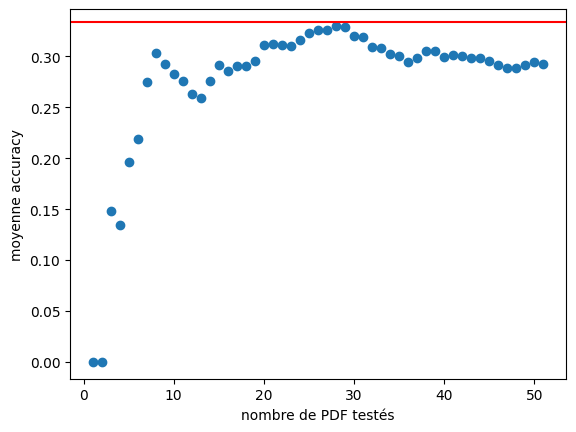

In [48]:
sum=0
total=[]
moyennes=[]
for i in results.index:
    sum=0
    for j in range(1,i):
        sum=results['accuracy'][j]+ sum
        #print(sum)
    tot=i+1
    total.append(tot)
    #print('total',tot)
    moy=(sum/tot)
    #print('moy:',moy)
    moyennes.append(moy)
    #results['f1_moy'][i]=moy
xpoints = total
ypoints = moyennes

plt.plot(xpoints, ypoints,"o")
plt.axhline(y = 1/3, color = 'r', linestyle = '-')
plt.ylabel('moyenne accuracy')

plt.xlabel('nombre de PDF testés')
plt.show()

In [50]:
moyennes[len(results)-1]
#moyenne accuracy

0.29286220043572975

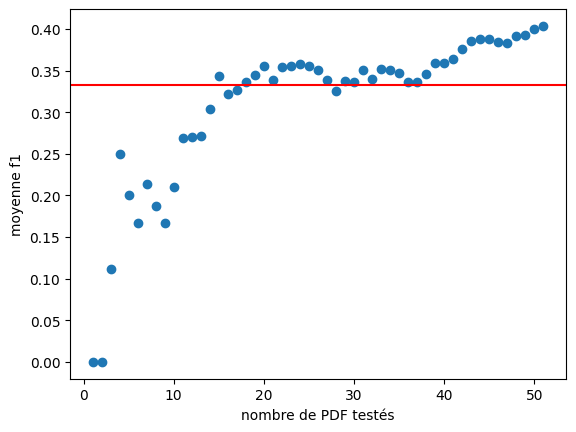

In [43]:
sum=0
total=[]
moyennes=[]
for i in results.index:
    sum=0
    for j in range(1,i):
        sum=results['f1'][j]+ sum
        #print(sum)
    tot=i+1
    total.append(tot)
    #print('total',tot)
    moy=(sum/tot)
    #print('moy:',moy)
    moyennes.append(moy)
    #results['f1_moy'][i]=moy
xpoints = total
ypoints = moyennes

plt.plot(xpoints, ypoints,"o")
plt.axhline(y = 1/3, color = 'r', linestyle = '-')
plt.ylabel('moyenne f1')

plt.xlabel('nombre de PDF testés')
plt.show()

In [47]:
moyennes[len(results)-1]
#moyenne f1

0.40372549019607845

In [424]:
temp= results

<BarContainer object of 51 artists>

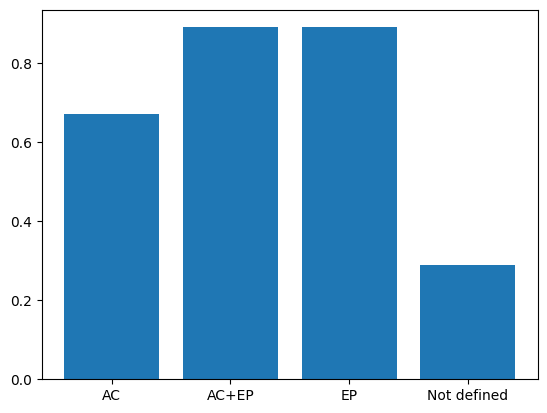

In [408]:
plt.bar(results["service"],
        results["f1"]
        )

<BarContainer object of 51 artists>

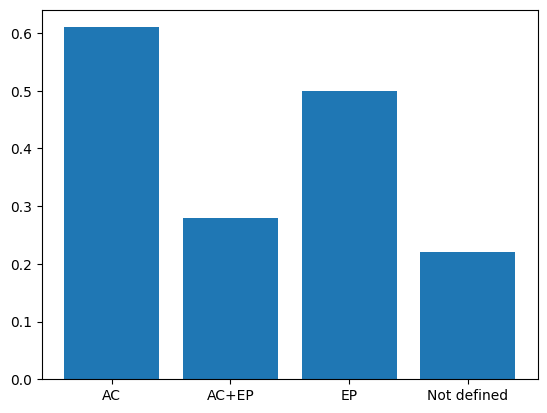

In [56]:
plt.bar(results["service"],
        results["accuracy"]
        )

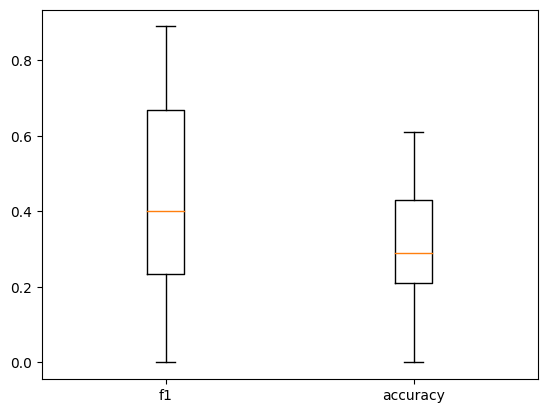

In [60]:
my_dict={"f1": results["f1"],"accuracy": results["accuracy"]}
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())

fig.savefig('boxplot.png')

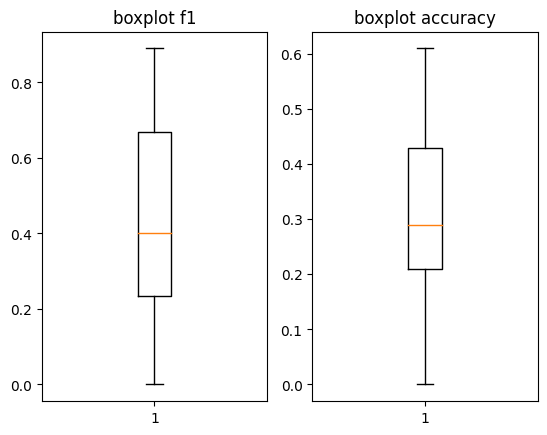

In [428]:
figure, axis = plt.subplots(1, 2)
  
# For Sine Function
axis[0].boxplot(results["f1"])
axis[0].set_title("boxplot f1")
  
# For Cosine Function
axis[ 1].boxplot(results["accuracy"])
axis[1].set_title("boxplot accuracy")

# show plot
plt.show()

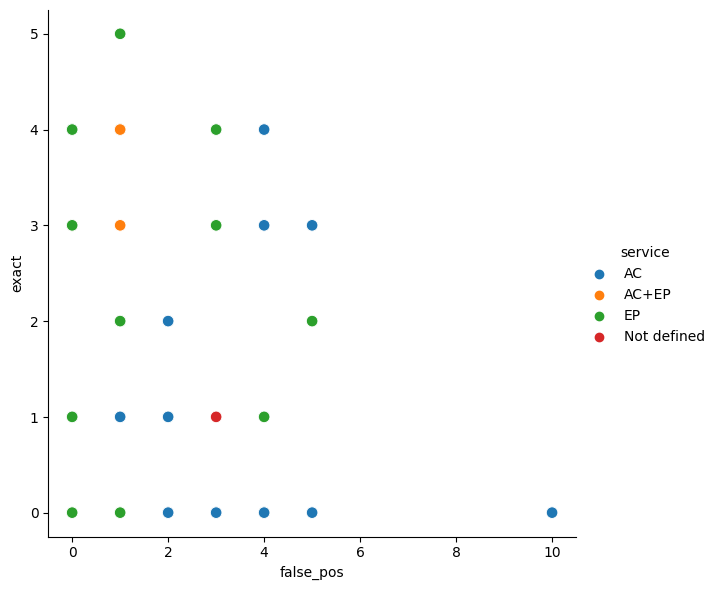

In [40]:
import seaborn as sns
sns.relplot(x="false_pos",y="exact",hue="service",data=results,height=6,s=70) ; plt.show()

In [51]:
results.groupby('service')['accuracy'].mean()

service
AC             0.353750
AC+EP          0.197917
EP             0.275909
Not defined    0.170000
Name: accuracy, dtype: float64

In [52]:
results.groupby('service')['precision'].mean()

service
AC             0.347639
AC+EP          0.850000
EP             0.636364
Not defined    0.375000
Name: precision, dtype: float64

In [53]:
results.groupby('service')['recall'].mean()

service
AC             0.297222
AC+EP          0.750000
EP             0.506818
Not defined    0.185000
Name: recall, dtype: float64

In [54]:
results.groupby('service')['f1'].mean()

service
AC             0.286806
AC+EP          0.768889
EP             0.526364
Not defined    0.245000
Name: f1, dtype: float64

In [429]:
BUCKET_OUT = "mberthe/narval"
FILE_KEY_OUT_S3 = "camemBERT/results.csv"#modif nom csv
FILE_PATH_OUT_S3 = BUCKET_OUT + "/" + FILE_KEY_OUT_S3

with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    results.to_csv(file_out,index=False,sep=';')